Fork the code from `"Energy Based.ipynb"` for comparison. The only modification is using non-energy based instead of energy based (c.f. the code `# XXX: the only modification.`). 

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from node.core import get_node_function
from node.fix_grid import RKSolver
from node.utils.trajectory import tracer, visualize_trajectory
from node.energy_based import Energy, energy_based, identity


# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


class MyLayer(tf.keras.layers.Layer):

    def __init__(self, units, dt, num_grids, **kwargs):
        super().__init__(**kwargs)
        self.dt = dt
        self.num_grids = num_grids

        t0 = tf.constant(0., dtype=DTYPE)
        self.tN = t0 + num_grids * dt

        self._model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', dtype=DTYPE),
            tf.keras.layers.Dense(units, dtype=DTYPE),
        ])
        self._model.build([None, units])

        self._raw_pvf = lambda _, x: self._model(x)
        self._pvf = energy_based(identity, identity, self._raw_pvf)
        self._node_fn = get_node_function(RKSolver(self.dt, dtype=DTYPE),
                                          tf.constant(0., dtype=DTYPE),
                                          self._raw_pvf)  # XXX: the only modification.

    def call(self, x):
        y = self._node_fn(self.tN, x)
        return y

    def get_config(self):
        return super().get_config().copy()


def process(X, y):
    X = X / 255.
    X = np.reshape(X, [-1, 28 * 28])
    y = np.eye(10)[y]
    return X.astype(DTYPE), y.astype(DTYPE)


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = process(x_train, y_train)
x_test, y_test = process(x_test, y_test)

scalar = StandardScaler()
scalar.fit(x_train)
x_train = scalar.transform(x_train)
x_test = scalar.transform(x_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
    MyLayer(64, dt=1e-1, num_grids=10),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Nadam(1e-3, epsilon=1e-2),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=12, batch_size=128)

Train on 60000 samples
Epoch 1/12
60000/60000 [==============================] - 21s 346us/sample - loss: 0.3928 - accuracy: 0.8928
Epoch 2/12
60000/60000 [==============================] - 15s 257us/sample - loss: 0.1757 - accuracy: 0.9501
Epoch 3/12
60000/60000 [==============================] - 15s 252us/sample - loss: 0.1252 - accuracy: 0.9635
Epoch 4/12
60000/60000 [==============================] - 16s 260us/sample - loss: 0.0989 - accuracy: 0.9712
Epoch 5/12
60000/60000 [==============================] - 15s 243us/sample - loss: 0.0799 - accuracy: 0.9762
Epoch 6/12
60000/60000 [==============================] - 15s 256us/sample - loss: 0.0646 - accuracy: 0.9803
Epoch 7/12
60000/60000 [==============================] - 16s 264us/sample - loss: 0.0545 - accuracy: 0.9828
Epoch 8/12
60000/60000 [==============================] - 16s 262us/sample - loss: 0.0461 - accuracy: 0.9861
Epoch 9/12
60000/60000 [==============================] - 16s 271us/sample - loss: 0.0382 - accuracy: 0.9

In [5]:
longer_trajectory_model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
    MyLayer(64, dt=1e-1, num_grids=30),
    tf.keras.layers.Dense(10, activation='softmax')
])

longer_trajectory_model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'])

longer_trajectory_model.set_weights(model.get_weights())
longer_trajectory_model.evaluate(x_train, y_train, batch_size=128)

60000/60000 [==============================] - 11s 186us/sample - loss: 4.0961 - accuracy: 0.7250


[4.09614633509318, 0.72503334]

In [7]:
my_layer_id = 1
my_layer = model.layers[my_layer_id]
trace = tracer(RKSolver(0.1), my_layer._pvf)
energy_fn = Energy(identity, my_layer._pvf)

truncated_model = tf.keras.Sequential(model.layers[:my_layer_id])
hidden = truncated_model(x_train[:100])
labels = y_train[:100]
trajectory = trace(t0=tf.constant(0.),
                   t1=tf.constant(10.),
                   dt=tf.constant(0.1),
                   x=hidden)
# trajectory = tf.stack([model.layers[3](_) for _ in tf.unstack(trajectory, axis=1)], axis=1)

def energy_along_trajectory(trajectory):
    shape = trajectory.get_shape().as_list()
    batch_size, trajectory_size, *phase_dims = shape
    phase_points = tf.reshape(trajectory, [-1, *phase_dims])
    e = energy_fn(phase_points)
    return tf.reshape(e, [batch_size, trajectory_size])


energy = energy_along_trajectory(trajectory)

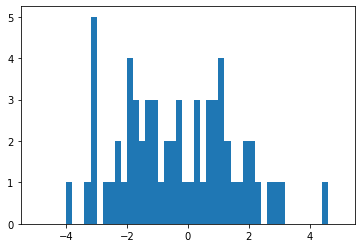

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


i = 15
diffs = (trajectory[:,-1,:] - trajectory[:,0,:])
plt.hist(diffs[i], bins=50, range=(-5, 5))
plt.show()